El modelo es adaptación del propuesto por Ayush y Sayak (2020) en su artículo "Introduction to image inpainting with deep learning". Este se puede encontrar en https://wandb.ai/site/articles/introduction-to-image-inpainting-with-deep-learning 

Ejecutar siempre


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
!git clone https://github.com/ayulockin/deepimageinpainting.git

In [ ]:
%cd deepimageinpainting/

In [3]:
import tensorflow as tf
import numpy as np
import sklearn as skl
import tensorflow_datasets as tfds

from sklearn import datasets
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from utils.pconv_layer import PConv2D

import cv2
import os

In [4]:
res = 256

In [5]:
from tensorflow import keras
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=6, dim=(res, res), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    
    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((res,res,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(4, 9)):
      # Get random x locations to start5 line
      x1, x2 = np.random.randint(1, res), np.random.randint(1, res)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, res), np.random.randint(1, res)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 5)
      # Draw black line on the white mask
      if(np.random.randint(1,3)==2):
        thickness = np.random.randint(2, 7)
        cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)
      else:
        radius = np.random.randint(5, 30)
        cv2.circle(mask, (x1,x2), radius, (0,0,0), -1)

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

In [6]:
# Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [16]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  
        
        m_images = []
        binary_masks = []
        predictions = []
        labels = []
        
        for i in range(6):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

Primera Fase de entrenamiento(Ejecutar la seccion "Ejecutar Siempre"). Para pruebas, ir a la sección pruebas despues de terminar de ejecutar

In [27]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(res,res,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2
  


In [ ]:
imagenetteDS, imagenetteDSVal = tfds.load('imagenette', split = ['train[0:9469]', 'validation[0:3925]'])

In [ ]:
!gdown --id 1yCDg9GNlDYq4hTgMqSzPvsPJzt5qvMoY -O /content/celebA3000.zip
!unzip /content/celebA3000.zip -d /content
facesDataDir= "/content/celebA3000/"

In [35]:
data = []

In [36]:

for file in os.listdir(facesDataDir):
  filename = file.split(".")
  if len(filename) == 2 and file.split(".")[1] == "jpg":
    img = cv2.imread(facesDataDir+file, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (res,res), interpolation = cv2.INTER_LINEAR)
    #image=np.array(img)
    #image = image.astype('float32')
    #image /= 255 
    data.append(img)                       
          
    blurProb = np.random.randint(1, 10)
    if blurProb == 5:
      blurred_img = cv2.GaussianBlur(img,(19,19),0)
      #cv2.imwrite("/content/celebA1250/"+file+"GB.jpg", img)
      #image=np.array(blurred_img)
      #image = image.astype('float32')
      #image /= 255 
      data.append(blurred_img)    

In [37]:
for src in imagenetteDS:
  img = np.array(src['image'])
  img = cv2.resize(img, (res,res))
  data.append(img)

  blurProb = np.random.randint(1, 10)
  if blurProb == 5:
    blurred_img = cv2.GaussianBlur(img,(19,19),0)
    data.append(blurred_img)

for src in imagenetteDSVal:
  img = np.array(src['image'])
  img = cv2.resize(img, (res,res))
  data.append(img)

  blurProb = np.random.randint(1, 10)
  if blurProb == 5:
    blurred_img = cv2.GaussianBlur(img,(19,19),0)
    data.append(blurred_img)
     

In [38]:
data = np.asarray(data) 
xTrain, xTest = train_test_split(data, test_size = 0.20, random_state = 0)
data = []

In [39]:
traingen = createAugment(xTrain,xTrain)
testgen = createAugment(xTest,xTest)

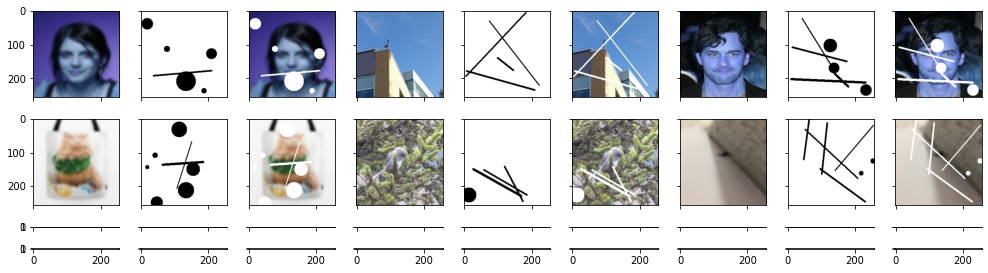

In [40]:
sample_idx = 2 ## Change this to see different batches

[masked_images, masks], sample_labels = testgen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

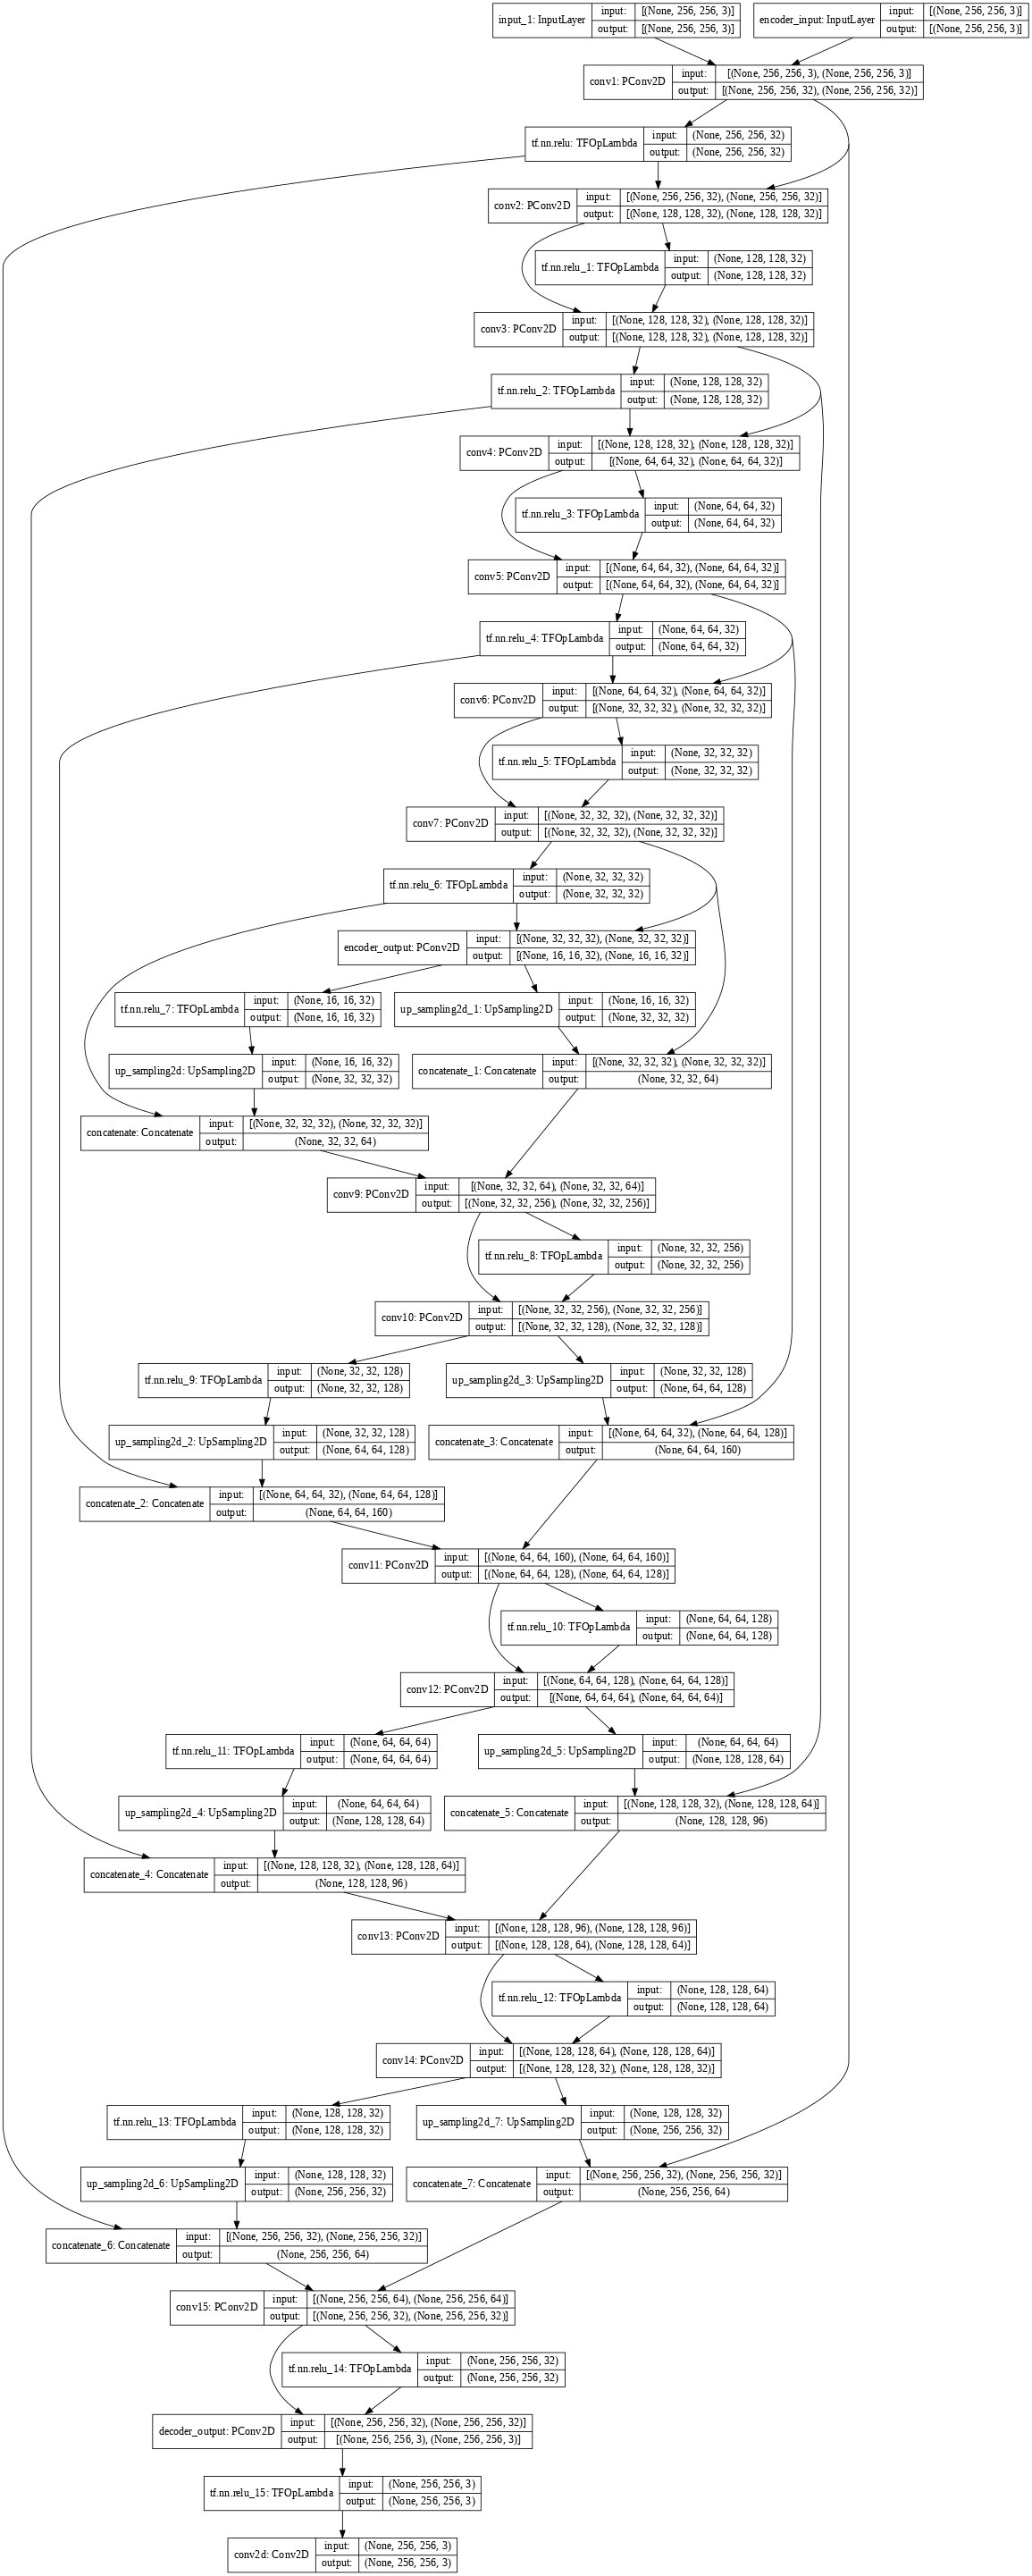

In [30]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
# model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

In [ ]:
# Primera fase de entrenamiento
_ = model.fit(traingen, validation_data=testgen,
          epochs=19,
          verbose = 2, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=False,
          callbacks=[PredictionLogger()])
model.save('/content/gdrive/My Drive/Patrones/inpainting.h5')

Epoch 1/19
2432/2432 - 565s - loss: 0.0972 - dice_coef: 0.5825 - val_loss: 0.0840 - val_dice_coef: 0.5917
Epoch 2/19
2432/2432 - 562s - loss: 0.0825 - dice_coef: 0.5955 - val_loss: 0.0817 - val_dice_coef: 0.5922
Epoch 3/19
2432/2432 - 562s - loss: 0.0809 - dice_coef: 0.5966 - val_loss: 0.0802 - val_dice_coef: 0.5945
Epoch 4/19
2432/2432 - 562s - loss: 0.0779 - dice_coef: 0.5992 - val_loss: 0.0738 - val_dice_coef: 0.5990
Epoch 5/19
2432/2432 - 562s - loss: 0.0556 - dice_coef: 0.6094 - val_loss: 0.0473 - val_dice_coef: 0.6111
Epoch 6/19
2432/2432 - 563s - loss: 0.0435 - dice_coef: 0.6161 - val_loss: 0.0398 - val_dice_coef: 0.6167
Epoch 7/19
2432/2432 - 564s - loss: 0.0383 - dice_coef: 0.6183 - val_loss: 0.0368 - val_dice_coef: 0.6147
Epoch 8/19
2432/2432 - 564s - loss: 0.0357 - dice_coef: 0.6197 - val_loss: 0.0355 - val_dice_coef: 0.6218
Epoch 9/19
2432/2432 - 563s - loss: 0.0340 - dice_coef: 0.6207 - val_loss: 0.0330 - val_dice_coef: 0.6174
Epoch 10/19
2432/2432 - 563s - loss: 0.0329 - 

Segunda fase de entrenamiento (Reiniciar entorno de ejecución(Si esta inicializado) y ejecutar la seccion "Ejecutar Siempre"). Para pruebas, ir a la sección pruebas después de ejecutar el entrenamiento

In [ ]:
# Segunda fase de entrenamiento, mayor enfasis en rostros
imagenetteDS = tfds.load('imagenet_a', split = 'test[0:2000]')

In [ ]:
# Segunda fase de entrenamiento, mayor enfasis en rostros
!gdown --id 1Zuio6Ge4IBow6cz8D14_mb2MMEa061il -O /content/celebA3000_2.zip
!unzip /content/celebA3000_2.zip -d /content
facesDataDir= "/content/celebA3000_2/"

In [9]:
data = []

In [10]:

for file in os.listdir(facesDataDir):
  filename = file.split(".")
  if len(filename) == 2 and file.split(".")[1] == "jpg":
    img = cv2.imread(facesDataDir+file, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (res,res), interpolation = cv2.INTER_LINEAR)
    #image=np.array(img)
    #image = image.astype('float32')
    #image /= 255 
    data.append(img)                       
          
    blurProb = np.random.randint(1, 10)
    if blurProb == 5:
      blurred_img = cv2.GaussianBlur(img,(19,19),0)
      #cv2.imwrite("/content/celebA1250/"+file+"GB.jpg", img)
      #image=np.array(blurred_img)
      #image = image.astype('float32')
      #image /= 255 
      data.append(blurred_img)     

In [11]:
for src in imagenetteDS:
  img = np.array(src['image'])
  img = cv2.resize(img, (res,res))
  data.append(img)

  blurProb = np.random.randint(1, 10)
  if blurProb == 5:
    blurred_img = cv2.GaussianBlur(img,(19,19),0)
    data.append(blurred_img)
     

In [12]:
data = np.asarray(data) 
xTrain, xTest = train_test_split(data, test_size = 0.20, random_state = 0)
data = []

In [13]:
traingen = createAugment(xTrain,xTrain)
testgen = createAugment(xTest,xTest)

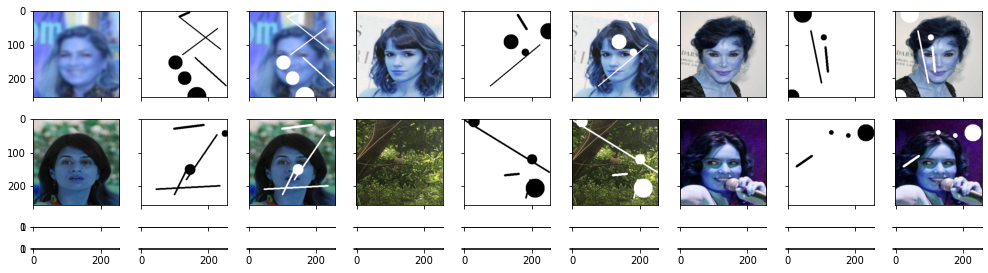

In [14]:
sample_idx = 2 ## Change this to see different batches

[masked_images, masks], sample_labels = testgen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [ ]:
from keras.models import load_model
#Descomentar las siguientes 2 lineas si se desea descargar un modelo preentrenado, correspondiente a la primera fase, si no, ejecutar la primera fase antes de la segunda
%cd /content
!gdown --id 1FJEWU2iN-7ScFD-RrAkKnvDi4yFyPYG3
model = load_model('/content/inpainting.h5', custom_objects={'PConv2D': PConv2D,'dice_coef':dice_coef})

#Comentar la siguiente linea si se descomentan las 2 anteriores
#model = load_model('/content/gdrive/My Drive/Patrones/inpainting.h5', custom_objects={'PConv2D': PConv2D,'dice_coef':dice_coef})

In [18]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

In [21]:
model.fit(traingen, validation_data=testgen,
          epochs=24,
          verbose = 2, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=False,
          callbacks=[PredictionLogger()])
model.save('/content/gdrive/My Drive/Patrones/inpainting2.h5')

Epoch 1/24
743/743 - 173s - loss: 0.0214 - dice_coef: 0.6132 - val_loss: 0.0216 - val_dice_coef: 0.6166
Epoch 2/24
743/743 - 176s - loss: 0.0212 - dice_coef: 0.6132 - val_loss: 0.0220 - val_dice_coef: 0.6149
Epoch 3/24
743/743 - 176s - loss: 0.0212 - dice_coef: 0.6123 - val_loss: 0.0215 - val_dice_coef: 0.6183
Epoch 4/24
743/743 - 176s - loss: 0.0212 - dice_coef: 0.6126 - val_loss: 0.0220 - val_dice_coef: 0.6145
Epoch 5/24
743/743 - 176s - loss: 0.0211 - dice_coef: 0.6129 - val_loss: 0.0216 - val_dice_coef: 0.6161
Epoch 6/24
743/743 - 176s - loss: 0.0210 - dice_coef: 0.6128 - val_loss: 0.0222 - val_dice_coef: 0.6186
Epoch 7/24
743/743 - 176s - loss: 0.0211 - dice_coef: 0.6123 - val_loss: 0.0211 - val_dice_coef: 0.6163
Epoch 8/24
743/743 - 176s - loss: 0.0210 - dice_coef: 0.6127 - val_loss: 0.0211 - val_dice_coef: 0.6164
Epoch 9/24
743/743 - 176s - loss: 0.0208 - dice_coef: 0.6129 - val_loss: 0.0211 - val_dice_coef: 0.6178
Epoch 10/24
743/743 - 176s - loss: 0.0208 - dice_coef: 0.6132 - 

Pruebas

In [ ]:
#Descomentar las siguientes 3 lineas si se desea descargar un modelo preentrenado, correspondiente a la segunda fase, si no, ejecutar la segunda o ambas fases anteriores
#from keras.models import load_model
#!gdown --id 
#model = load_model('/content/inpainting.h5', custom_objects={'PConv2D': PConv2D,'dice_coef':dice_coef})

#Comentar la siguiente linea si se descomentan las 3 anteriores
model = load_model('/content/gdrive/My Drive/Patrones/inpainting2.h5', custom_objects={'PConv2D': PConv2D,'dice_coef':dice_coef})


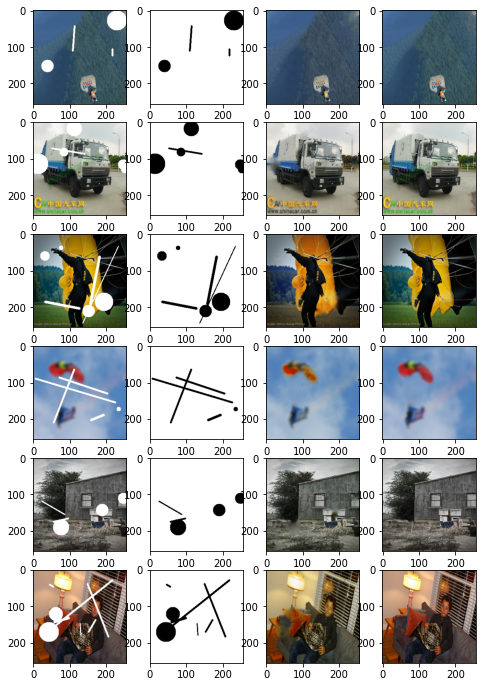

In [ ]:
rows = 6
sample_idx = 50
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8,2*rows))

for i in range(6):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  #inputs = [masked_images[i], masks[i]]
  impainted_image = model.predict(inputs)
  axs[i][0].imshow(masked_images[i])
  axs[i][1].imshow(masks[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(sample_labels[i])
  
plt.show()